In [101]:
!pip install causalnex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
! apt install libgraphviz-dev


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [103]:
!pip install pygraphviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
!pip install causalnex.utils.network_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement causalnex.utils.network_utils (from versions: none)
ERROR: No matching distribution found for causalnex.utils.network_utils


In [105]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from causalnex.structure.notears import from_pandas,from_pandas_lasso
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report,roc_auc
import networkx as nx
from causalnex.discretiser.discretiser_strategy import DecisionTreeSupervisedDiscretiserMethod



from IPython.display import Image


In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
data = pd.read_csv("/content/drive/MyDrive/Data/data-selected.csv")


In [108]:
data.head()

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,diagnosis
0,184.60,1937.05,25.38,0.2654,0.14710,122.80,1001.0,17.99,86.20,0.28241,0.7119,1
1,158.80,1937.05,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,0.08690,0.2416,1
2,152.50,1709.00,23.57,0.2430,0.12790,130.00,1203.0,19.69,86.20,0.19740,0.4504,1
3,98.87,567.70,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,0.24140,0.6869,1
4,152.20,1575.00,22.54,0.1625,0.10430,135.10,1297.0,20.29,86.20,0.19800,0.4000,1


##### Split data into training and hold-out set 

In [109]:
X = data.iloc[:,:-1]
y = data[['diagnosis']]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)


### Scaling 

In [111]:
scaler = MinMaxScaler()
X_train_scaler = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)

In [112]:
causal_data = X_train_scaler.join(y_train)
causal_data.head()

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,diagnosis
0,0.082879,0.059004,0.086892,0.601375,0.283107,0.109164,0.069297,0.094166,0.136880,1.000000,1.000000,1.0
1,0.918439,1.000000,0.958471,0.997595,0.968065,0.951845,0.986764,0.942994,0.940301,0.880635,0.863144,1.0
2,0.083556,0.050483,0.070919,0.174811,0.141068,0.113281,0.078294,0.104300,0.210559,0.212032,0.177849,NaN
3,0.176823,0.135458,0.190182,0.210859,0.104507,0.201757,0.152781,0.208248,0.123907,0.084239,0.143221,1.0
4,0.115699,0.084625,0.124694,0.088625,0.083476,0.167010,0.122415,0.174467,0.350361,0.038384,0.027600,1.0


In [113]:
causal_data.dropna(subset=['diagnosis'],inplace=True)

In [114]:
causal_data.head()

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,diagnosis
0,0.082879,0.059004,0.086892,0.601375,0.283107,0.109164,0.069297,0.094166,0.136880,1.000000,1.000000,1.0
1,0.918439,1.000000,0.958471,0.997595,0.968065,0.951845,0.986764,0.942994,0.940301,0.880635,0.863144,1.0
3,0.176823,0.135458,0.190182,0.210859,0.104507,0.201757,0.152781,0.208248,0.123907,0.084239,0.143221,1.0
4,0.115699,0.084625,0.124694,0.088625,0.083476,0.167010,0.122415,0.174467,0.350361,0.038384,0.027600,1.0
5,0.523994,0.419971,0.467575,0.588316,0.476526,0.490183,0.422528,0.482018,0.324290,0.580362,0.894462,1.0


In [115]:
def structuremodel(sm,label):
    viz = plot_structure(sm,
                         graph_attributes={"scale": "2.0", 'size':2.5,"label":label},
                         all_node_attributes=NODE_STYLE.WEAK,
                         all_edge_attributes=EDGE_STYLE.WEAK,
                         prog='fdp',
                         )
    return Image(viz.draw(format='png'))


#### Create a causal graph using all training data and get the insights (this will be considered the ground truth)


In [116]:
sm = from_pandas(causal_data)

In [117]:
sm.remove_edges_below_threshold(0.8)

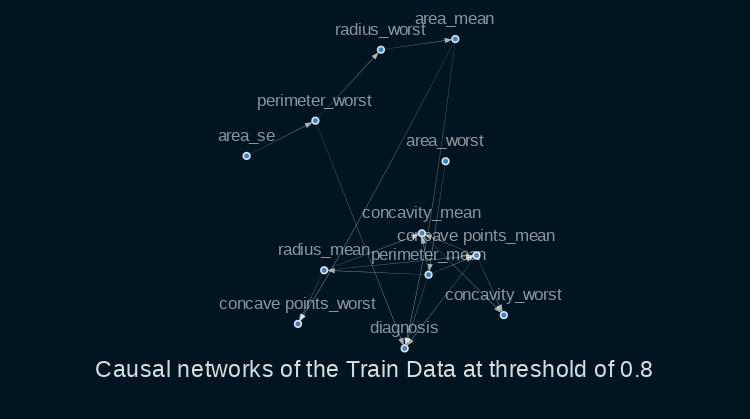

In [118]:
structuremodel(sm,"Causal networks of the Train Data at threshold of 0.8")

## Create new causal graphs using increasing fractions of the data and compare with the ground truth graph


# Jaccard's similarity index


In [119]:
def jaccard_index(a,b):
  i = a.edges
  j = b.edges 

  r = set(i).intersection(j)
  result = round(len(r) / (len(i) + len(j) - len(r)),2) 
  print(f'The jaccard simillarity index between {a} and {b} is {result}')

##### Splitting into samples fractions

In [120]:
sample_20 = causal_data.sample(frac=0.2, random_state=42)
sample_40 = causal_data.sample(frac=0.4, random_state=42)
sample_60 = causal_data.sample(frac=0.6, random_state=42)
sample_80 = causal_data.sample(frac=0.8, random_state=42)

In [121]:
sm_20 = from_pandas(sample_20,w_threshold=0.8)
sm_40 = from_pandas(sample_40,w_threshold=0.8)
sm_60 = from_pandas(sample_60,w_threshold=0.8)
sm_80 = from_pandas(sample_80,w_threshold=0.8)


In [122]:
sm_ = from_pandas(causal_data,w_threshold=0.8)

In [123]:
jaccard_index(sm_,sm_20)

The jaccard simillarity index between StructureModel with 12 nodes and 18 edges and StructureModel with 12 nodes and 34 edges is 0.24


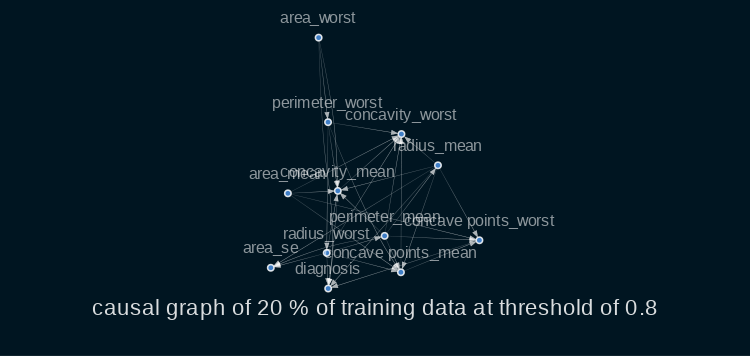

In [124]:
structuremodel(sm_20,"causal graph of 20 % of training data at threshold of 0.8")

In [125]:
jaccard_index(sm_,sm_40)

The jaccard simillarity index between StructureModel with 12 nodes and 18 edges and StructureModel with 12 nodes and 27 edges is 0.41


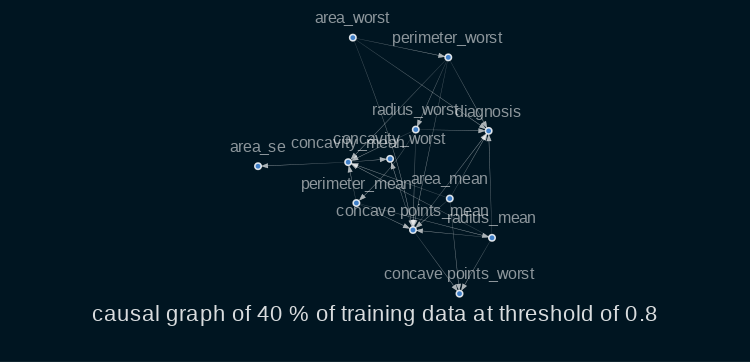

In [126]:
structuremodel(sm_40,"causal graph of 40 % of training data at threshold of 0.8")

In [127]:
jaccard_index(sm_,sm_60)

The jaccard simillarity index between StructureModel with 12 nodes and 18 edges and StructureModel with 12 nodes and 17 edges is 0.75


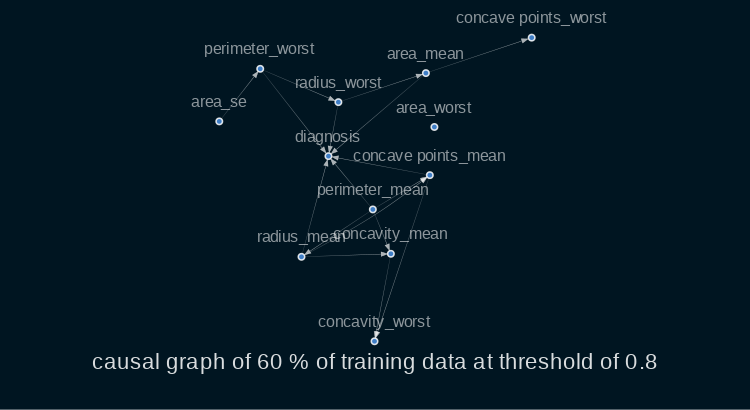

In [128]:
structuremodel(sm_60,"causal graph of 60 % of training data at threshold of 0.8")

In [129]:
jaccard_index(sm_,sm_80)

The jaccard simillarity index between StructureModel with 12 nodes and 18 edges and StructureModel with 12 nodes and 19 edges is 0.95


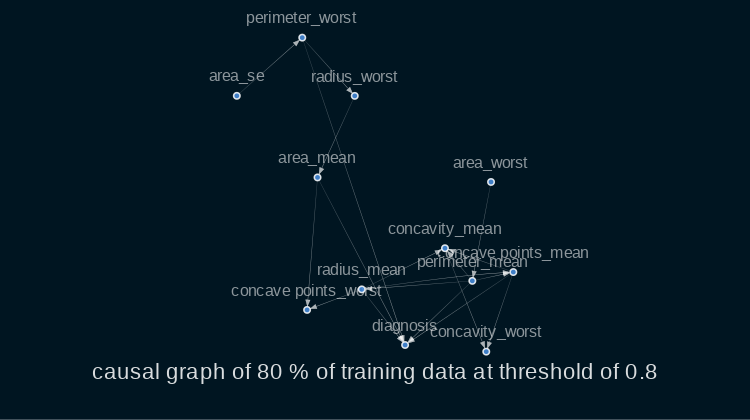

In [130]:
structuremodel(sm_80,"causal graph of 80 % of training data at threshold of 0.8")

with 80 of sample data we have 0.95 of jaccard index and graph is stable we can extract features that directly affect diagnosis

## Diagnosis direct features 

In [131]:
nodes = dict(dict(sm_80.edges).keys())
nodes

{'area_mean': 'diagnosis',
 'area_se': 'perimeter_worst',
 'area_worst': 'perimeter_mean',
 'concave points_mean': 'diagnosis',
 'concavity_mean': 'concavity_worst',
 'perimeter_mean': 'diagnosis',
 'perimeter_worst': 'diagnosis',
 'radius_mean': 'diagnosis',
 'radius_worst': 'area_mean'}

In [132]:
direct_features = []
for keys,values in nodes.items():
  if values == "diagnosis":
    direct_features.append(keys)

In [133]:
direct_features

['perimeter_worst',
 'concave points_mean',
 'perimeter_mean',
 'area_mean',
 'radius_mean']

In [134]:
direct_features_ = ['perimeter_worst',
 'concave points_mean',
 'perimeter_mean',
 'area_mean',
 'radius_mean','diagnosis']

5 features were selected 

## dataset with features selected 

In [135]:
causal_selected_df =  data[direct_features_]

In [136]:
causal_selected_df.head()

,perimeter_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,diagnosis
0,184.60,0.14710,122.80,1001.0,17.99,1
1,158.80,0.07017,132.90,1326.0,20.57,1
2,152.50,0.12790,130.00,1203.0,19.69,1
3,98.87,0.10520,77.58,386.1,11.42,1
4,152.20,0.10430,135.10,1297.0,20.29,1


In [137]:
from google.colab import files
causal_selected_df.to_csv('causal_selected.csv', encoding = 'utf-8-sig') 
files.download('causal_selected.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
all_data = pd.read_csv("/content/drive/MyDrive/Data/data-cleaned.csv")

In [139]:
all_data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,0.07871,...,17.33,184.60,1937.05,0.1622,0.62695,0.7119,0.2654,0.41915,0.11890,M
1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1937.05,0.1238,0.18660,0.2416,0.1860,0.27500,0.08902,M
2,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.00,0.1444,0.42450,0.4504,0.2430,0.36130,0.08758,M
3,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,0.07875,...,26.50,98.87,567.70,0.1901,0.62695,0.6869,0.2575,0.41915,0.12301,M
4,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.00,0.1374,0.20500,0.4000,0.1625,0.23640,0.07678,M


In [140]:
all_data['diagnosis']=LabelEncoder().fit_transform(all_data['diagnosis'])

In [141]:
all_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,0.07871,...,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890,1
1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902,1
2,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758,1
3,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,0.07875,...,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301,1
4,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115,1
565,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637,1
566,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820,1
567,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,0.2397,0.07016,...,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301,1


In [142]:
X_all_data = all_data.iloc[:,:-1]

In [143]:
X_all_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890
1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902
2,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758
3,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,0.07875,...,14.910,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301
4,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115
565,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637
566,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820
567,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301


In [144]:
scaler = MinMaxScaler()

In [145]:
scaler.fit(X_all_data)

MinMaxScaler()

In [146]:
X_all_data_scaler = pd.DataFrame(scaler.transform(X_all_data),columns= X_all_data.columns)

In [147]:
X_all_data_scaler.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.737918,0.032627,0.761873,0.724975,0.798006,1.000000,1.000000,0.951888,0.966716,0.998611,...,0.893497,0.173190,0.980026,1.000000,0.762755,1.000000,0.906302,0.912027,1.000000,0.939532
1,0.910852,0.392501,0.859264,0.999746,0.353473,0.283215,0.307709,0.454072,0.517751,0.233067,...,0.873528,0.371494,0.791601,1.000000,0.436224,0.265667,0.307575,0.639175,0.451171,0.499926
2,0.851867,0.561967,0.831300,0.895756,0.681788,0.671573,0.698984,0.827644,0.707840,0.348385,...,0.800819,0.440639,0.745591,0.869823,0.611395,0.662392,0.573393,0.835052,0.779745,0.478741
3,0.297540,0.519601,0.325828,0.205107,1.000000,1.000000,0.854786,0.680752,1.000000,1.000000,...,0.357399,0.472277,0.353916,0.218341,1.000000,1.000000,0.874475,0.884880,1.000000,1.000000
4,0.892084,0.225469,0.880478,0.975228,0.558967,0.542057,0.701108,0.674928,0.515533,0.308093,...,0.748080,0.151663,0.743400,0.793333,0.551871,0.296351,0.509230,0.558419,0.304207,0.319847


In [148]:
all_data = X_all_data_scaler.join(all_data['diagnosis'])

In [149]:
all_data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.737918,0.032627,0.761873,0.724975,0.798006,1.000000,1.000000,0.951888,0.966716,0.998611,...,0.173190,0.980026,1.000000,0.762755,1.000000,0.906302,0.912027,1.000000,0.939532,1
1,0.910852,0.392501,0.859264,0.999746,0.353473,0.283215,0.307709,0.454072,0.517751,0.233067,...,0.371494,0.791601,1.000000,0.436224,0.265667,0.307575,0.639175,0.451171,0.499926,1
2,0.851867,0.561967,0.831300,0.895756,0.681788,0.671573,0.698984,0.827644,0.707840,0.348385,...,0.440639,0.745591,0.869823,0.611395,0.662392,0.573393,0.835052,0.779745,0.478741,1
3,0.297540,0.519601,0.325828,0.205107,1.000000,1.000000,0.854786,0.680752,1.000000,1.000000,...,0.472277,0.353916,0.218341,1.000000,1.000000,0.874475,0.884880,1.000000,1.000000,1
4,0.892084,0.225469,0.880478,0.975228,0.558967,0.542057,0.701108,0.674928,0.515533,0.308093,...,0.151663,0.743400,0.793333,0.551871,0.296351,0.509230,0.558419,0.304207,0.319847,1


In [150]:
# scaler.fit(causal_selected_df)
# causal_selected_df = pd.DataFrame(scaler.transform(causal_selected_df),columns= causal_selected_df.columns)
# causal_selected_df = causal_selected_df.join(all_data['diagnosis'])

X_selected = causal_selected_df.iloc[:,:-1]
scaler.fit(X_selected)
X_selected_scaler = pd.DataFrame(scaler.transform(X_selected),columns=X_selected.columns)
Causal_selected_scaler  = X_selected_scaler.join(causal_selected_df['diagnosis'])
Causal_selected_scaler.head()

,perimeter_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,diagnosis
0,0.980026,0.951888,0.761873,0.724975,0.737918,1
1,0.791601,0.454072,0.859264,0.999746,0.910852,1
2,0.745591,0.827644,0.831300,0.895756,0.851867,1
3,0.353916,0.680752,0.325828,0.205107,0.297540,1
4,0.743400,0.674928,0.880478,0.975228,0.892084,1


In [151]:
all_data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.737918,0.032627,0.761873,0.724975,0.798006,1.000000,1.000000,0.951888,0.966716,0.998611,...,0.173190,0.980026,1.000000,0.762755,1.000000,0.906302,0.912027,1.000000,0.939532,1
1,0.910852,0.392501,0.859264,0.999746,0.353473,0.283215,0.307709,0.454072,0.517751,0.233067,...,0.371494,0.791601,1.000000,0.436224,0.265667,0.307575,0.639175,0.451171,0.499926,1
2,0.851867,0.561967,0.831300,0.895756,0.681788,0.671573,0.698984,0.827644,0.707840,0.348385,...,0.440639,0.745591,0.869823,0.611395,0.662392,0.573393,0.835052,0.779745,0.478741,1
3,0.297540,0.519601,0.325828,0.205107,1.000000,1.000000,0.854786,0.680752,1.000000,1.000000,...,0.472277,0.353916,0.218341,1.000000,1.000000,0.874475,0.884880,1.000000,1.000000,1
4,0.892084,0.225469,0.880478,0.975228,0.558967,0.542057,0.701108,0.674928,0.515533,0.308093,...,0.151663,0.743400,0.793333,0.551871,0.296351,0.509230,0.558419,0.304207,0.319847,1


In [152]:
def discretizer(features, df_feat):
    """
    This function transforms continous data into discrete values
    """
    tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
        mode='single',
        tree_params={'max_depth': 3, 'random_state': 27},
    )
    tree_discretiser.fit(
        feat_names=features,
        dataframe=df_feat,
        target_continuous=True,
        target='diagnosis',
    )
    discretised_data = df_feat.copy()
    for col in features:
        discretised_data[col] = tree_discretiser.transform(df_feat[[col]])
    return discretised_data

In [153]:
discretised_data = discretizer(list(all_data.columns), all_data)
discretised_data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,7,0,7,7,7,7,7,7,7,6,...,1,7,7,6,7,6,7,7,6,1
1,7,2,7,7,3,1,3,4,5,3,...,3,7,7,2,2,3,7,1,3,1
2,7,4,7,7,6,6,7,7,5,3,...,4,7,7,5,6,6,7,6,3,1
3,0,4,0,0,7,7,7,7,7,6,...,4,1,0,7,7,6,7,7,7,1
4,7,1,7,7,5,5,7,7,5,3,...,1,7,7,4,2,6,6,1,1,1


In [154]:
discretised_data_selected = discretizer(list(Causal_selected_scaler.columns), Causal_selected_scaler)
discretised_data_selected.head()

,perimeter_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,diagnosis
0,7,7,7,7,7,1
1,7,4,7,7,7,1
2,7,7,7,7,7,1
3,1,7,0,0,0,1
4,7,7,7,7,7,1


In [155]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)


In [156]:
train_selected, test_selected = train_test_split(discretised_data_selected, train_size=0.9, test_size=0.1, random_state=7)


In [157]:
sm_new=from_pandas(Causal_selected_scaler)
sm_new.remove_edges_below_threshold(0.8)

In [158]:
bn = BayesianNetwork(sm)


In [159]:
bn_new = BayesianNetwork(sm_new)

In [160]:
bn = bn.fit_node_states(discretised_data)


In [161]:
bn_new = bn_new.fit_node_states(discretised_data_selected)


In [162]:
bn=bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")


In [163]:
bn_new=bn_new.fit_cpds(train_selected, method="BayesianEstimator", bayes_prior="K2")


In [164]:
from causalnex.evaluation import classification_report


In [165]:
classification_report(bn, test, "diagnosis")


{'accuracy': 0.9298245614035088,
 'diagnosis_0': {'f1-score': 0.9444444444444444,
  'precision': 0.8947368421052632,
  'recall': 1.0,
  'support': 34},
 'diagnosis_1': {'f1-score': 0.9047619047619047,
  'precision': 1.0,
  'recall': 0.8260869565217391,
  'support': 23},
 'macro avg': {'f1-score': 0.9246031746031745,
  'precision': 0.9473684210526316,
  'recall': 0.9130434782608696,
  'support': 57},
 'weighted avg': {'f1-score': 0.9284321915900862,
  'precision': 0.9372114496768236,
  'recall': 0.9298245614035088,
  'support': 57}}

In [166]:
classification_report(bn_new, test_selected, "diagnosis")


{'accuracy': 0.9122807017543859,
 'diagnosis_0': {'f1-score': 0.9315068493150686,
  'precision': 0.8717948717948718,
  'recall': 1.0,
  'support': 34},
 'diagnosis_1': {'f1-score': 0.878048780487805,
  'precision': 1.0,
  'recall': 0.782608695652174,
  'support': 23},
 'macro avg': {'f1-score': 0.9047778149014367,
  'precision': 0.9358974358974359,
  'recall': 0.8913043478260869,
  'support': 57},
 'weighted avg': {'f1-score': 0.9099360496128394,
  'precision': 0.9235267656320288,
  'recall': 0.9122807017543859,
  'support': 57}}